In [427]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [428]:
def sample_data(n=10000, scale=1):
    x = np.linspace(-np.pi, np.pi, n)

    return np.vstack([x, np.sin(x)]).T

In [429]:
def plot(X):
    plt.scatter(X[:,0], X[:,1])

In [430]:
def gen_noise(batch_size):
    return tf.random.normal([batch_size, 2], 0, 1)

In [431]:
def print_values(model, X=None, batch_size=200):
    if X is None:
        X = sample_data(n=batch_size)
    plt.figure()
    
    Z = gen_noise(batch_size)

    x_gen = model(Z, training=False)
    
    plot(X)
    plot(x_gen)

## Tensorflow models

Epoch 1/30
18/18 [==============================] - 2s 3ms/step - g_loss: 0.6608 - d_loss: 0.6672 - d_total_loss: 1.3280
Epoch 2/30
18/18 [==============================] - 0s 3ms/step - g_loss: 0.6911 - d_loss: 0.6976 - d_total_loss: 1.3887
Epoch 3/30
18/18 [==============================] - 0s 4ms/step - g_loss: 0.7680 - d_loss: 0.6862 - d_total_loss: 1.4543
Epoch 4/30
18/18 [==============================] - 0s 4ms/step - g_loss: 0.7049 - d_loss: 0.6905 - d_total_loss: 1.3954
Epoch 5/30
18/18 [==============================] - 0s 4ms/step - g_loss: 0.6696 - d_loss: 0.6975 - d_total_loss: 1.3670
Epoch 6/30
18/18 [==============================] - 0s 3ms/step - g_loss: 0.7418 - d_loss: 0.6863 - d_total_loss: 1.4281
Epoch 7/30
18/18 [==============================] - 0s 4ms/step - g_loss: 0.6987 - d_loss: 0.6882 - d_total_loss: 1.3869
Epoch 8/30
18/18 [==============================] - 0s 3ms/step - g_loss: 0.7347 - d_loss: 0.6853 - d_total_loss: 1.4201
Epoch 9/30
18/18 [==============

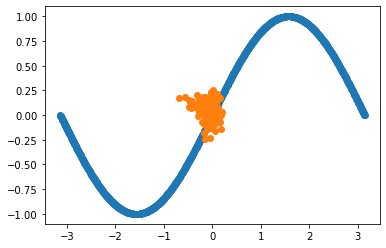

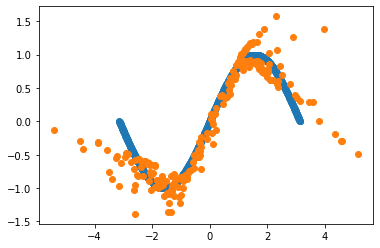

In [432]:
class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator):
        super(GAN, self).__init__()
        self.disc = discriminator
        self.gen = generator
        self.gen_loss_tracker = tf.keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = tf.keras.metrics.Mean(name="discriminator_loss")
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker, self.total_loss_tracker]


    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn


    def train_step(self, X):
        noise_dim = 2
        batch_size = tf.shape(X)[0]

        with tf.GradientTape() as disc_tape:
            noise = gen_noise(batch_size)
            generated_output = self.gen(noise)

            all_output = tf.concat([X, generated_output], axis=0)
            all_labels = tf.concat([tf.ones(batch_size,1), tf.zeros(batch_size,1)], axis=0)

            all_predictions = self.disc(all_output)

            disc_loss = self.loss_fn(all_labels, all_predictions)

        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.disc.trainable_variables)

        with tf.GradientTape() as gen_tape:
            noise = gen_noise(batch_size)
            generated_output = self.gen(noise)

            all_predictions = self.disc(generated_output)

            all_labels = tf.ones(batch_size,1)

            gen_loss = self.loss_fn(all_labels, all_predictions)


        gradients_of_generator = gen_tape.gradient(gen_loss, self.gen.trainable_variables)
        

        self.g_optimizer.apply_gradients(zip(gradients_of_generator, self.gen.trainable_variables))
        self.d_optimizer.apply_gradients(zip(gradients_of_discriminator, self.disc.trainable_variables))

        #Monitor loss.
        self.gen_loss_tracker.update_state(gen_loss)
        self.disc_loss_tracker.update_state(disc_loss)
        self.total_loss_tracker.update_state(gen_loss+disc_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
            "d_total_loss":  self.total_loss_tracker.result()
        }

gen = tf.keras.Sequential([
    tf.keras.layers.Dense(units=128, activation=tf.nn.leaky_relu),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=64, activation=tf.nn.leaky_relu),
    tf.keras.layers.Dense(units=2),
],name="generator")

disc = tf.keras.Sequential([
    tf.keras.layers.Dense(units=128, activation=tf.nn.leaky_relu),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=64, activation=tf.nn.leaky_relu),
    tf.keras.layers.Dense(units=2),
    tf.keras.layers.Dense(units=1)

],name="discriminator")

cond_gan = GAN(
    discriminator=disc, generator=gen
)

cond_gan.compile(
    d_optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
    g_optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
    loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True),
)

dataset = sample_data(n=10000, scale=1)
print_values(cond_gan.gen, dataset)

for i in range(1):
    dataset = sample_data(n=10000, scale=1)
    cond_gan.fit(dataset, epochs=30, batch_size=64)

    print_values(cond_gan.gen, dataset)


<Figure size 432x288 with 0 Axes>

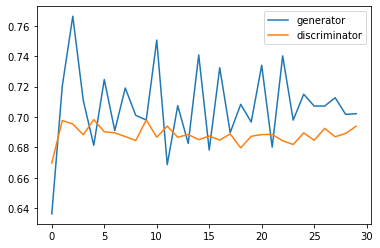

<Figure size 432x288 with 0 Axes>

In [433]:
plt.plot(cond_gan.history.history["g_loss"], label="generator")
plt.plot(cond_gan.history.history["d_loss"],  label="discriminator")
plt.legend()
plt.figure()